In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

# Change directory to the desired location in Google Drive
import os
os.chdir('/content/gdrive/MyDrive')

Mounted at /content/gdrive


In [ ]:
import os

# with Early Stopping Resnet-50

0    6102
1     290
Name: right_cataract, dtype: int64
['0_left.jpg' '81_left.jpg' '103_left.jpg' '119_left.jpg' '254_left.jpg'
 '294_left.jpg' '330_left.jpg' '448_left.jpg' '465_left.jpg'
 '477_left.jpg']
['24_right.jpg' '81_right.jpg' '112_right.jpg' '188_right.jpg'
 '218_right.jpg' '345_right.jpg' '354_right.jpg' '477_right.jpg'
 '553_right.jpg' '560_right.jpg' '625_right.jpg' '726_right.jpg'
 '769_right.jpg' '949_right.jpg' '955_right.jpg']
Number of images in left cataract: 304
Number of images in right cataract: 290
['2964_right.jpg' '680_right.jpg' '500_right.jpg' '2368_right.jpg'
 '2820_right.jpg' '2769_right.jpg' '2696_right.jpg' '2890_right.jpg'
 '940_right.jpg' '2553_right.jpg' '3371_right.jpg' '3042_right.jpg'
 '919_right.jpg' '3427_right.jpg' '379_right.jpg']
594 600


100%|██████████| 594/594 [00:07<00:00, 84.29it/s] 


588


100%|██████████| 600/600 [00:05<00:00, 115.25it/s]


1188


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_2 (Dense)             (None, 256)               25690368  
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 49,278,337
Trainable params: 49,225,217
Non-trainable params: 53,120
_________________________________________________________________
Epoch 1/20
30/30 [===================

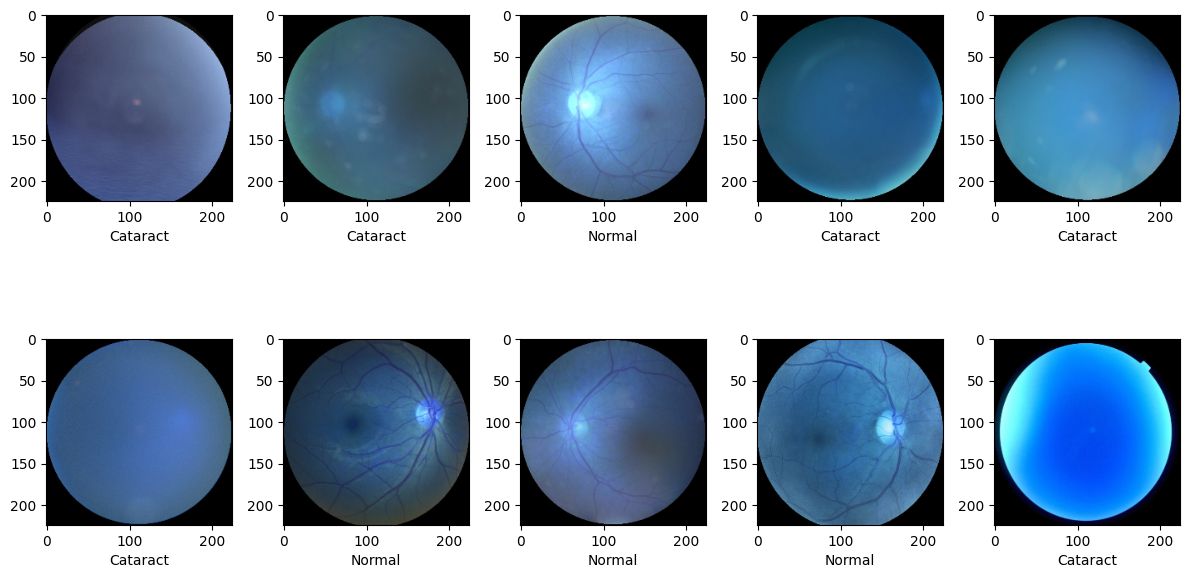

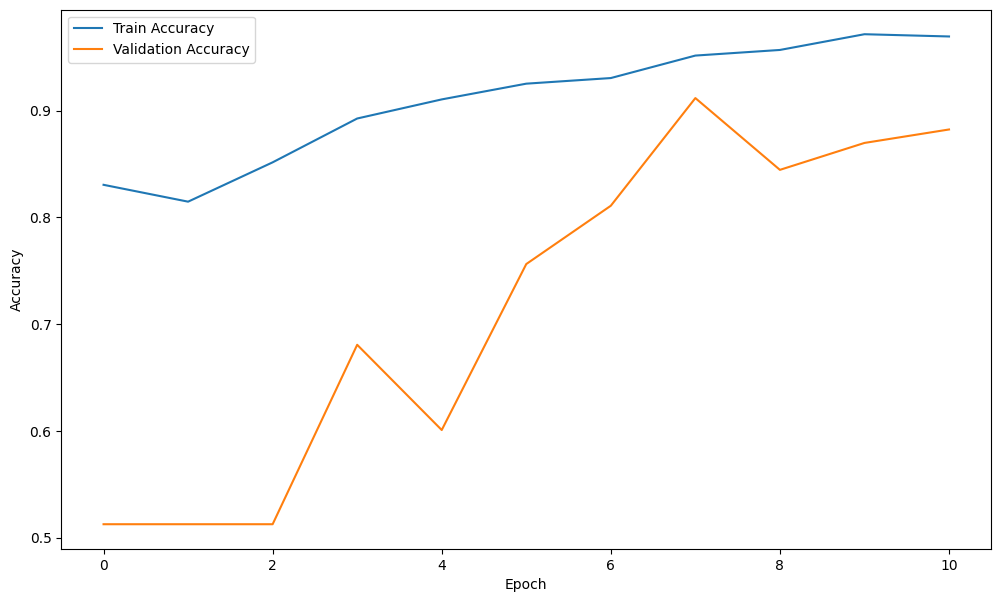

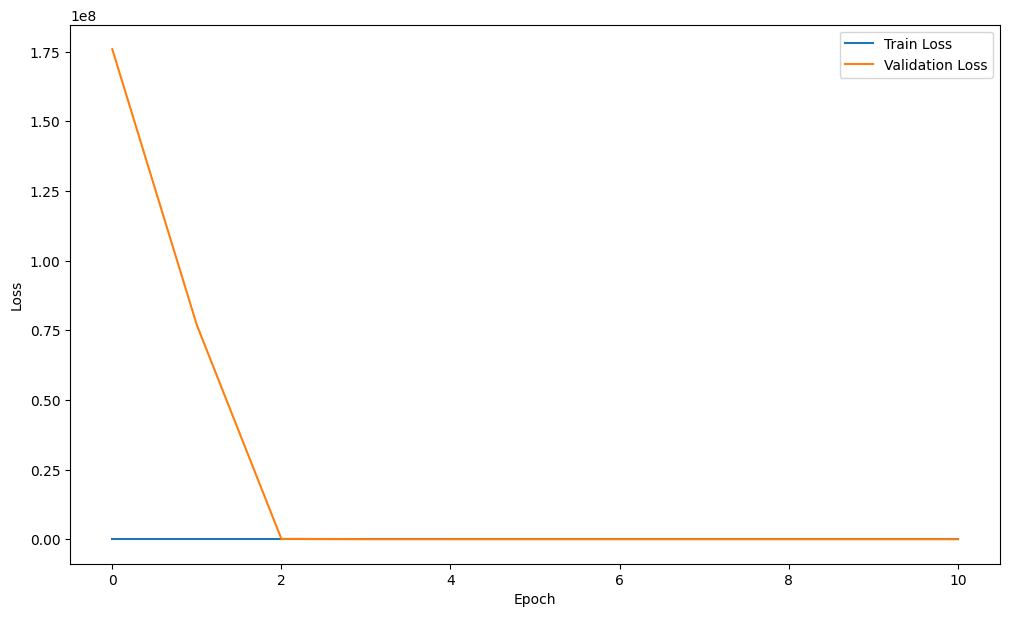

8/8 [==============================] - 47s 5s/step


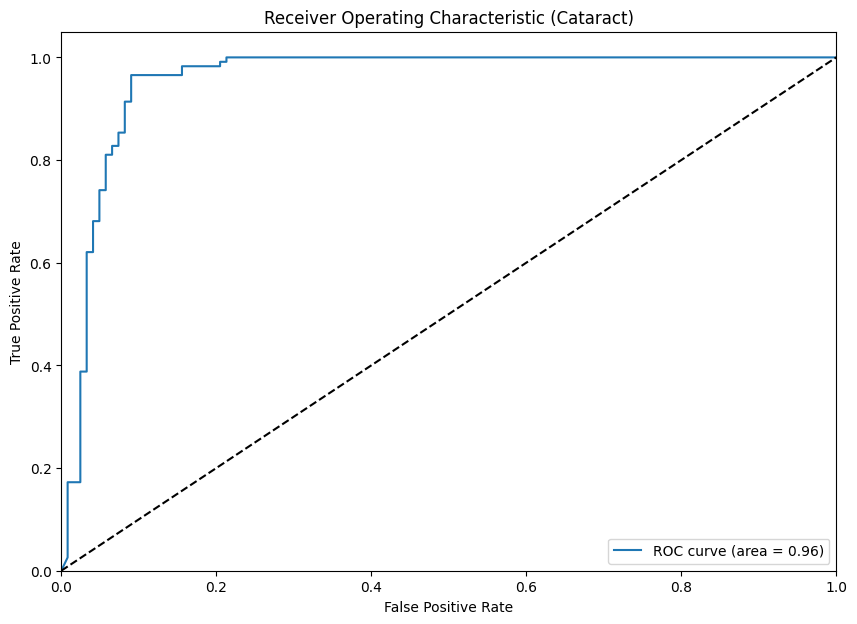

              precision    recall  f1-score   support

      Normal       0.98      0.84      0.91       122
    Cataract       0.86      0.98      0.92       116

    accuracy                           0.91       238
   macro avg       0.92      0.91      0.91       238
weighted avg       0.92      0.91      0.91       238

8/8 [==============================] - 45s 6s/step - loss: 0.4243 - accuracy: 0.9118
Test Loss: 0.42426154017448425
Test Accuracy: 0.9117646813392639


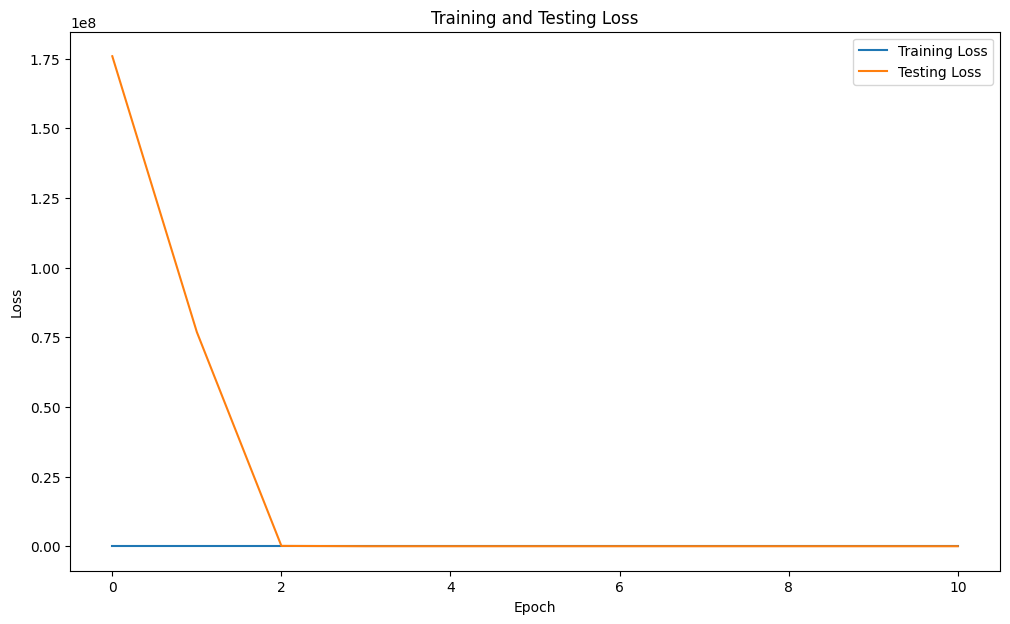

In [ ]:
import numpy as np
import pandas as pd
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Set random seed for reproducibility
random.seed(42)

# Read the CSV file
df = pd.read_csv("/content/full_df.csv")

# Define a function to check if a keyword contains "cataract"
def has_cataract(text):
    if "cataract" in text:
        return 1
    else:
        return 0

# Create new columns for left and right cataract
df["left_cataract"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_cataract(x))
df["right_cataract"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_cataract(x))

# Print the count of right cataract samples
print(df.right_cataract.value_counts())

# Get the filenames of left and right cataract images
left_cataract = df.loc[(df.C == 1) & (df.left_cataract == 1)]["Left-Fundus"].values
right_cataract = df.loc[(df.C == 1) & (df.right_cataract == 1)]["Right-Fundus"].values

# Print the first few filenames
print(left_cataract[:10])
print(right_cataract[:15])

# Print the number of images in left and right cataract
print("Number of images in left cataract: {}".format(len(left_cataract)))
print("Number of images in right cataract: {}".format(len(right_cataract)))

# Get a sample of normal fundus images for both left and right eyes
left_normal = df.loc[(df.C == 0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(300, random_state=42).values
right_normal = df.loc[(df.C == 0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(300, random_state=42).values

# Print the first few filenames
print(right_normal[:15])

# Concatenate cataract and normal filenames
cataract = np.concatenate((left_cataract, right_cataract), axis=0)
normal = np.concatenate((left_normal, right_normal), axis=0)

# Print the number of cataract and normal images
print(len(cataract), len(normal))

# Define the dataset directory and image size
dataset_dir = "/content/gdrive/MyDrive/Computer_vision_project/preprocessed_images"
image_size = 224

# Create an empty list for storing image data and labels
dataset = []

# Function to create the dataset
def create_dataset(image_category, label):
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir, img)
        try:
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            image = cv2.resize(image, (image_size, image_size))
        except:
            continue
        
        dataset.append([np.array(image), np.array(label)])
    
    random.shuffle(dataset)
    return dataset

# Create the cataract dataset
dataset = create_dataset(cataract, 1)

# Print the length of the cataract dataset
print(len(dataset))

# Create the normal dataset
dataset = create_dataset(normal, 0)

# Print the length of the normal dataset
print(len(dataset))

# Plot a sample of images from the dataset
plt.figure(figsize=(12, 7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    label = "Normal" if category == 0 else "Cataract"
    plt.subplot(2, 5, i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()

# Split the dataset into features (x) and labels (y)
x = np.array([i[0] for i in dataset]).reshape(-1, image_size, image_size, 3)
y = np.array([i[1] for i in dataset])

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Load the pre-trained ResNet-50 model
patha='/content/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
resnet = ResNet50(weights=patha, include_top=False, input_shape=(image_size, image_size, 3))

# Create a new model based on ResNet-50
model = Sequential()
model.add(resnet)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Define early stopping callback
early_stopping = EarlyStopping(patience=3, monitor='val_loss', mode='min', restore_best_weights=True)

# Train the model
history = model.fit(x_train, y_train, batch_size=32, epochs=20, validation_data=(x_test, y_test), callbacks=[early_stopping])

# Evaluate the model on the testing set
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

# Plot the training history
plt.figure(figsize=(12, 7))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss
plt.figure(figsize=(12, 7))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Generate predictions on the testing set
y_pred = model.predict(x_test)
y_pred_binary = (y_pred > 0.5).astype(int)

# Convert labels to binary format
y_test_binary = label_binarize(y_test, classes=[0, 1])
y_pred_proba = y_pred

# Compute ROC curve and AUC for each class
fpr, tpr, _ = roc_curve(y_test_binary, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve for cataract class
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Cataract)')
plt.legend(loc="lower right")
plt.show()

# Generate classification report
target_names = ['Normal', 'Cataract']
classification_rep = classification_report(y_test, y_pred_binary, target_names=target_names)
print(classification_rep)


# Evaluate the model on the testing set
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

# Plot the training and validation loss
plt.figure(figsize=(12, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Testing Loss')
plt.show()

0    6102
1     290
Name: right_cataract, dtype: int64
['0_left.jpg' '81_left.jpg' '103_left.jpg' '119_left.jpg' '254_left.jpg'
 '294_left.jpg' '330_left.jpg' '448_left.jpg' '465_left.jpg'
 '477_left.jpg']
['24_right.jpg' '81_right.jpg' '112_right.jpg' '188_right.jpg'
 '218_right.jpg' '345_right.jpg' '354_right.jpg' '477_right.jpg'
 '553_right.jpg' '560_right.jpg' '625_right.jpg' '726_right.jpg'
 '769_right.jpg' '949_right.jpg' '955_right.jpg']
Number of images in left cataract: 304
Number of images in right cataract: 290
['2964_right.jpg' '680_right.jpg' '500_right.jpg' '2368_right.jpg'
 '2820_right.jpg' '2769_right.jpg' '2696_right.jpg' '2890_right.jpg'
 '940_right.jpg' '2553_right.jpg' '3371_right.jpg' '3042_right.jpg'
 '919_right.jpg' '3427_right.jpg' '379_right.jpg']
594 600


100%|██████████| 594/594 [01:41<00:00,  5.87it/s] 


588


100%|██████████| 600/600 [02:21<00:00,  4.24it/s]


1188


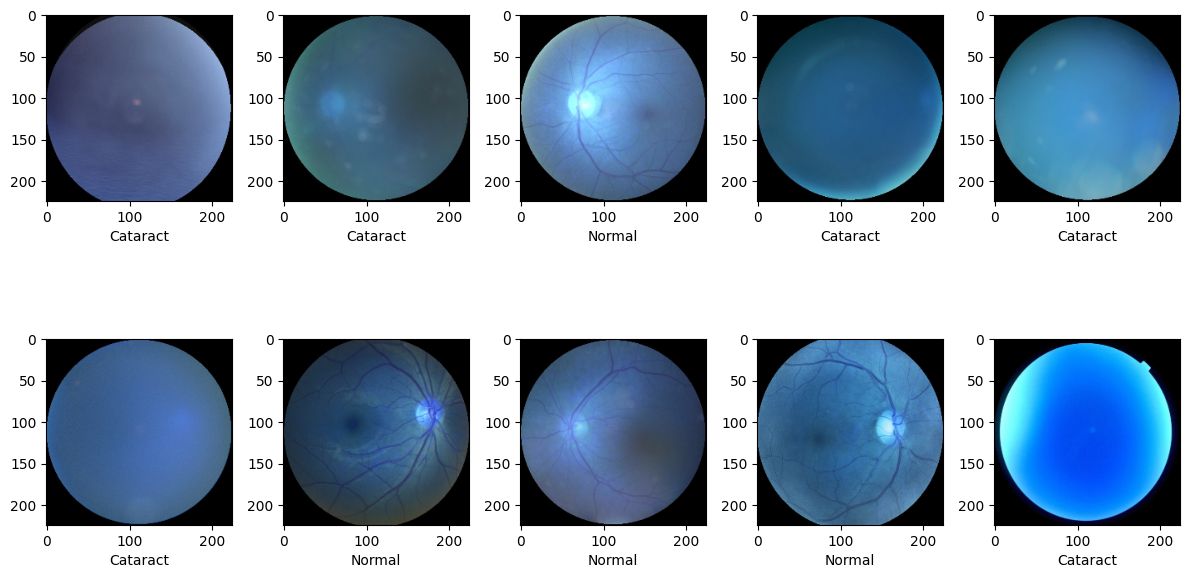

In [ ]:
import numpy as np
import pandas as pd
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Set random seed for reproducibility
random.seed(42)

# Read the CSV file
df = pd.read_csv("/content/full_df.csv")

# Define a function to check if a keyword contains "cataract"
def has_cataract(text):
    if "cataract" in text:
        return 1
    else:
        return 0

# Create new columns for left and right cataract
df["left_cataract"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_cataract(x))
df["right_cataract"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_cataract(x))

# Print the count of right cataract samples
print(df.right_cataract.value_counts())

# Get the filenames of left and right cataract images
left_cataract = df.loc[(df.C == 1) & (df.left_cataract == 1)]["Left-Fundus"].values
right_cataract = df.loc[(df.C == 1) & (df.right_cataract == 1)]["Right-Fundus"].values

# Print the first few filenames
print(left_cataract[:10])
print(right_cataract[:15])

# Print the number of images in left and right cataract
print("Number of images in left cataract: {}".format(len(left_cataract)))
print("Number of images in right cataract: {}".format(len(right_cataract)))

# Get a sample of normal fundus images for both left and right eyes
left_normal = df.loc[(df.C == 0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(300, random_state=42).values
right_normal = df.loc[(df.C == 0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(300, random_state=42).values

# Print the first few filenames
print(right_normal[:15])

# Concatenate cataract and normal filenames
cataract = np.concatenate((left_cataract, right_cataract), axis=0)
normal = np.concatenate((left_normal, right_normal), axis=0)

# Print the number of cataract and normal images
print(len(cataract), len(normal))

# Define the dataset directory and image size
dataset_dir = "/content/gdrive/MyDrive/Computer_vision_project/preprocessed_images"
image_size = 224

# Create an empty list for storing image data and labels
dataset = []

# Function to create the dataset
def create_dataset(image_category, label):
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir, img)
        try:
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            image = cv2.resize(image, (image_size, image_size))
        except:
            continue
        
        dataset.append([np.array(image), np.array(label)])
    
    random.shuffle(dataset)
    return dataset

# Create the cataract dataset
dataset = create_dataset(cataract, 1)

# Print the length of the cataract dataset
print(len(dataset))

# Create the normal dataset
dataset = create_dataset(normal, 0)

# Print the length of the normal dataset
print(len(dataset))

# Plot a sample of images from the dataset
plt.figure(figsize=(12, 7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    label = "Normal" if category == 0 else "Cataract"
    plt.subplot(2, 5, i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()

# Split the dataset into features (x) and labels (y)
x = np.array([i[0] for i in dataset]).reshape(-1, image_size, image_size, 3)
y = np.array([i[1] for i in dataset])

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


# VGG16 model

58889256/58889256 [==============================] - 0s 0us/step


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 21,137,729
Trainable params: 21,137,729
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
30/30 [==========================

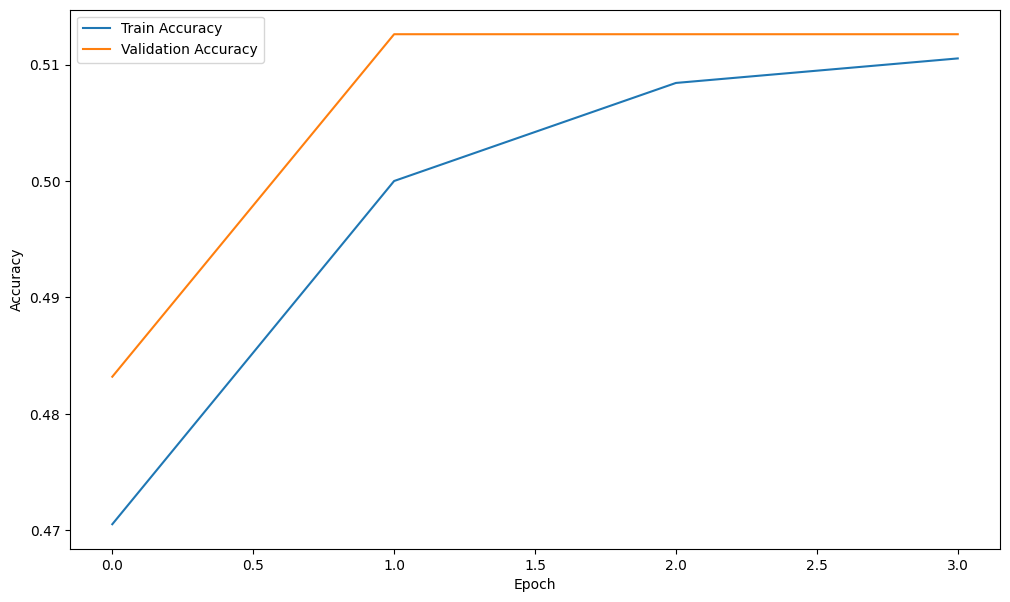

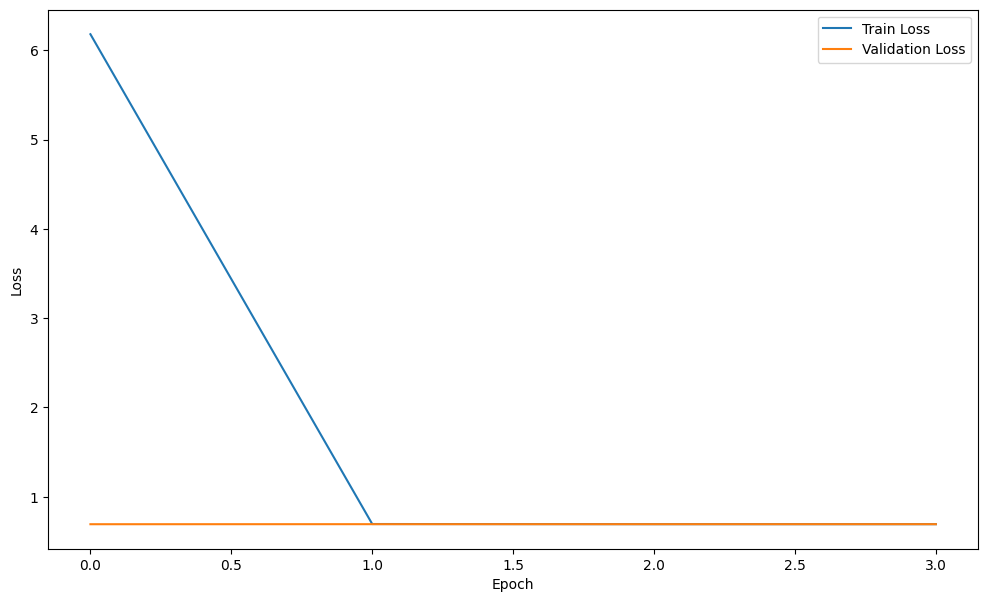

8/8 [==============================] - 146s 18s/step


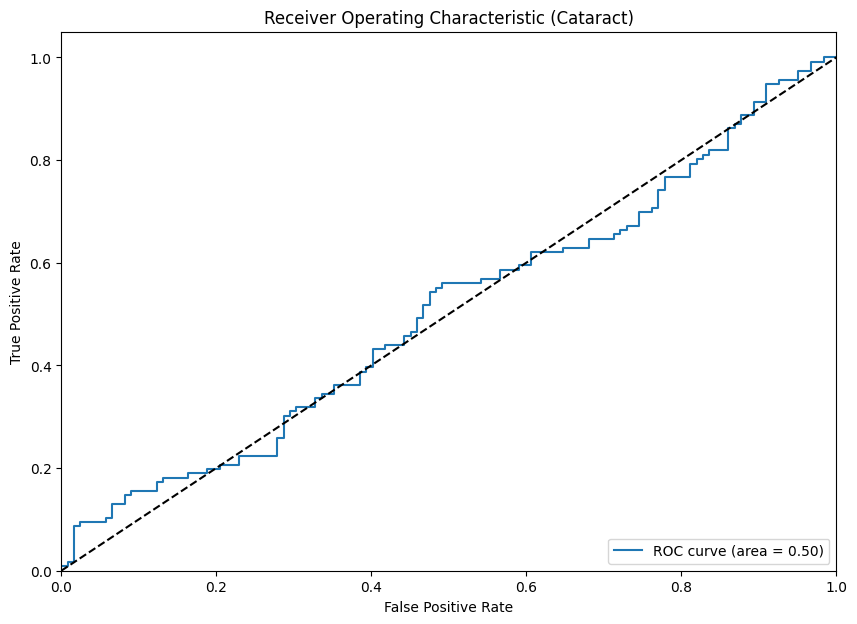

              precision    recall  f1-score   support

      Normal       0.49      0.21      0.30       122
    Cataract       0.48      0.77      0.59       116

    accuracy                           0.48       238
   macro avg       0.49      0.49      0.44       238
weighted avg       0.49      0.48      0.44       238

8/8 [==============================] - 148s 18s/step - loss: 0.6927 - accuracy: 0.4832
Test Loss: 0.6926661133766174
Test Accuracy: 0.4831932783126831


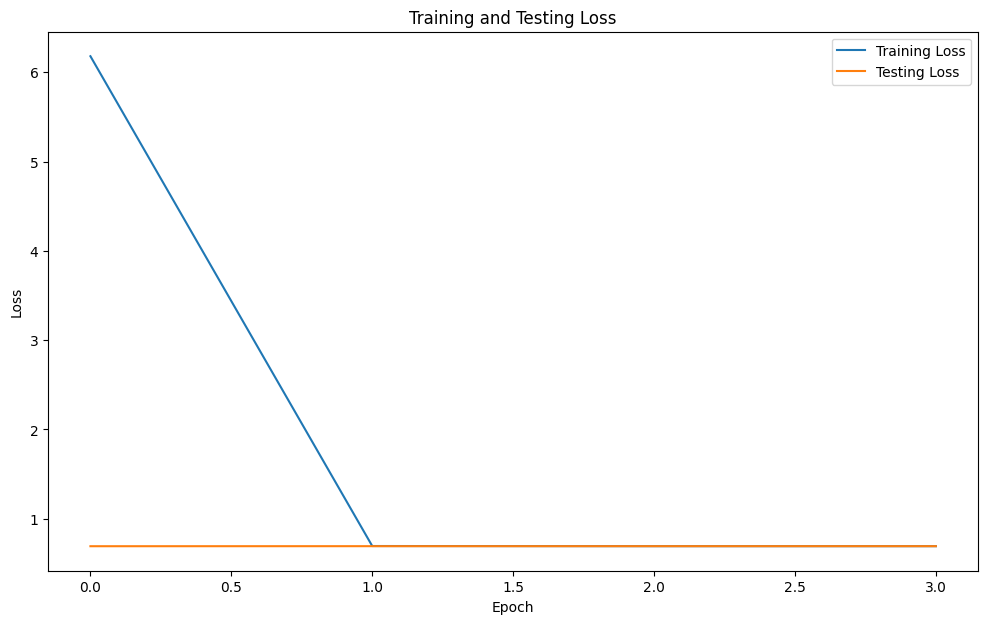

Training Time: 10300.225271701813 seconds


In [ ]:
import time
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Start the timer
start_time = time.time()

# Load the pre-trained VGG16 model
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Create a new model based on VGG16
model = Sequential()
model.add(vgg16)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Define early stopping callback
early_stopping = EarlyStopping(patience=3, monitor='val_loss', mode='min', restore_best_weights=True)

# Train the model
history = model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_test, y_test), callbacks=[early_stopping])

# Evaluate the model on the testing set
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

# Plot the training history
plt.figure(figsize=(12, 7))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss
plt.figure(figsize=(12, 7))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Generate predictions on the testing set
y_pred = model.predict(x_test)
y_pred_binary = (y_pred > 0.5).astype(int)

# Convert labels to binary format
y_test_binary = label_binarize(y_test, classes=[0, 1])
y_pred_proba = y_pred

# Compute ROC curve and AUC for each class
fpr, tpr, _ = roc_curve(y_test_binary, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve for cataract class
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Cataract)')
plt.legend(loc="lower right")
plt.show()

# Generate classification report
target_names = ['Normal', 'Cataract']
classification_rep = classification_report(y_test, y_pred_binary, target_names=target_names)
print(classification_rep)

# Evaluate the model on the testing set
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

# Plot the training and validation loss
plt.figure(figsize=(12, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Testing Loss')
plt.show()

# Calculate the training time
training_time = time.time() - start_time

# Print the training time
print('Training Time:', training_time, 'seconds')


# DenseNet 121

29084464/29084464 [==============================] - 0s 0us/step


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 flatten_1 (Flatten)         (None, 50176)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               12845312  
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 19,883,073
Trainable params: 19,799,425
Non-trainable params: 83,648
_________________________________________________________________
Epoch 1/10
30/30 [===================

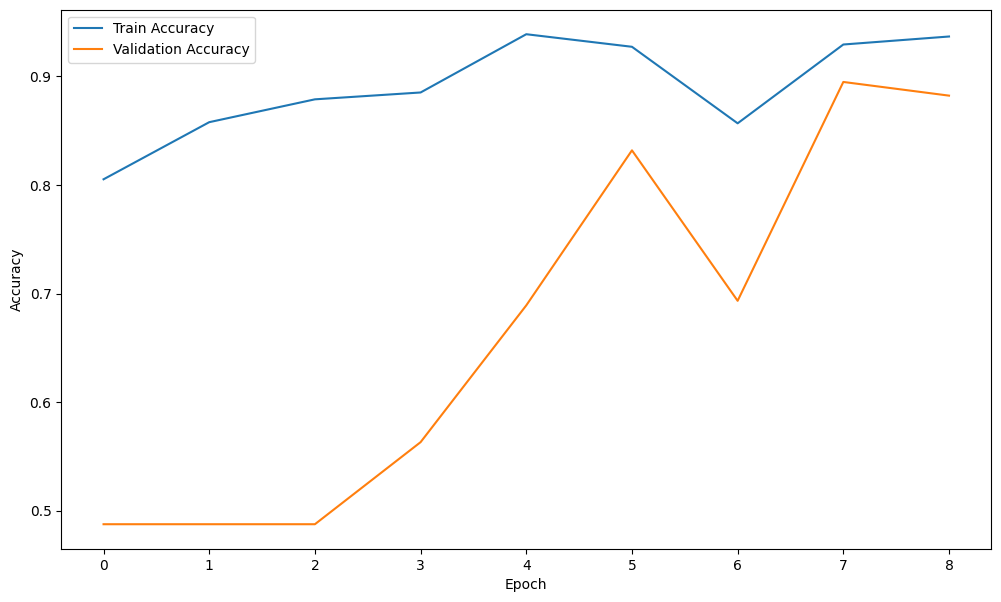

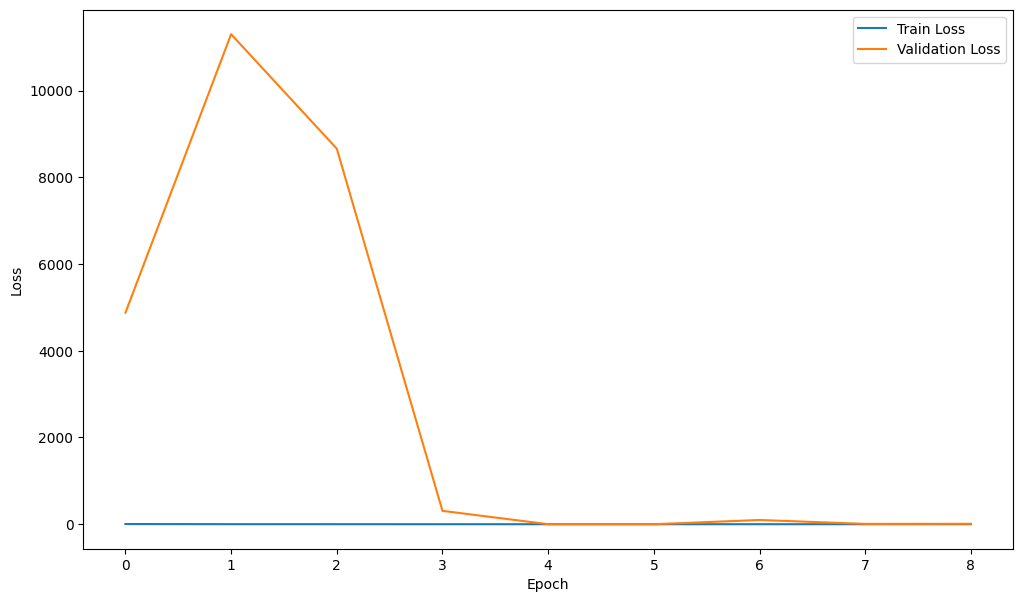

8/8 [==============================] - 43s 5s/step


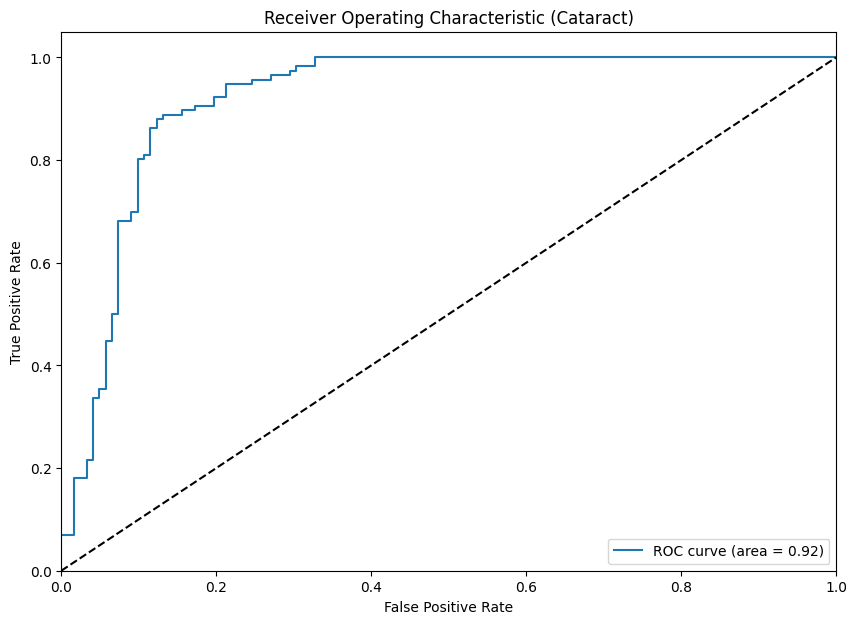

              precision    recall  f1-score   support

      Normal       1.00      0.67      0.80       122
    Cataract       0.74      1.00      0.85       116

    accuracy                           0.83       238
   macro avg       0.87      0.84      0.83       238
weighted avg       0.88      0.83      0.83       238

8/8 [==============================] - 39s 5s/step - loss: 0.4863 - accuracy: 0.8319
Test Loss: 0.4863419830799103
Test Accuracy: 0.831932783126831


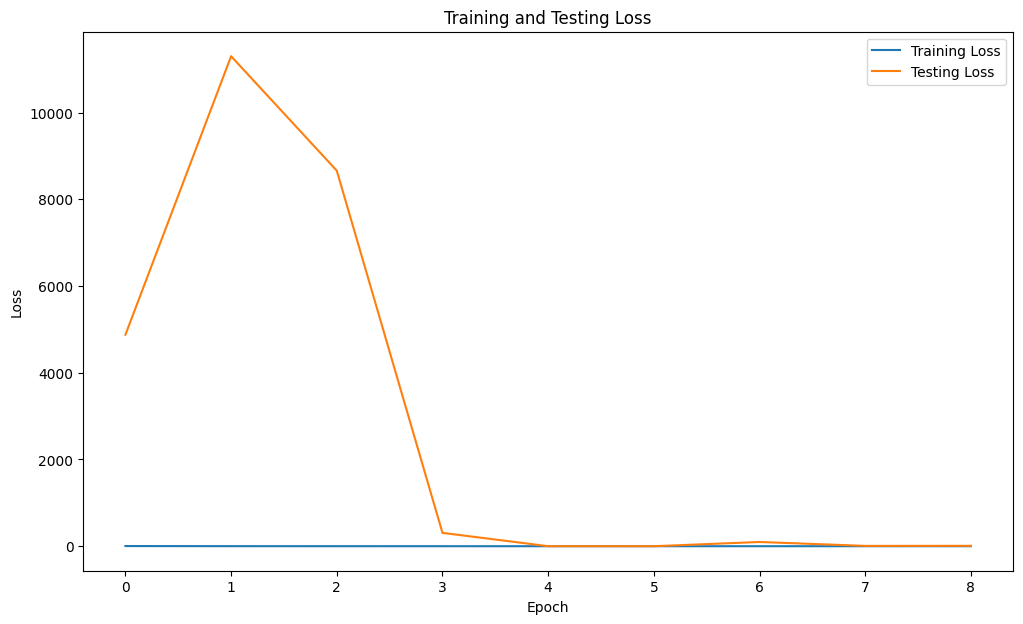

Training Time: 8359.786651849747 seconds


In [ ]:
import time
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Start the timer
start_time = time.time()

# Load the pre-trained DenseNet-121 model
densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Create a new model based on DenseNet-121
model = Sequential()
model.add(densenet)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Define early stopping callback
early_stopping = EarlyStopping(patience=3, monitor='val_loss', mode='min', restore_best_weights=True)

# Train the model
history = model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_test, y_test), callbacks=[early_stopping])

# Evaluate the model on the testing set
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

# Plot the training history
plt.figure(figsize=(12, 7))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss
plt.figure(figsize=(12, 7))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Generate predictions on the testing set
y_pred = model.predict(x_test)
y_pred_binary = (y_pred > 0.5).astype(int)

# Convert labels to binary format
y_test_binary = label_binarize(y_test, classes=[0, 1])
y_pred_proba = y_pred

# Compute ROC curve and AUC for each class
fpr, tpr, _ = roc_curve(y_test_binary, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve for cataract class
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Cataract)')
plt.legend(loc="lower right")
plt.show()

# Generate classification report
target_names = ['Normal', 'Cataract']
classification_rep = classification_report(y_test, y_pred_binary, target_names=target_names)
print(classification_rep)

# Evaluate the model on the testing set
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

# Plot the training and validation loss
plt.figure(figsize=(12, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Testing Loss')
plt.show()

# Calculate the training time
training_time = time.time() - start_time

# Print the training time
print('Training Time:', training_time, 'seconds')


0    6102
1     290
Name: right_cataract, dtype: int64
['0_left.jpg' '81_left.jpg' '103_left.jpg' '119_left.jpg' '254_left.jpg'
 '294_left.jpg' '330_left.jpg' '448_left.jpg' '465_left.jpg'
 '477_left.jpg']
['24_right.jpg' '81_right.jpg' '112_right.jpg' '188_right.jpg'
 '218_right.jpg' '345_right.jpg' '354_right.jpg' '477_right.jpg'
 '553_right.jpg' '560_right.jpg' '625_right.jpg' '726_right.jpg'
 '769_right.jpg' '949_right.jpg' '955_right.jpg']
Number of images in left cataract: 304
Number of images in right cataract: 290
['2964_right.jpg' '680_right.jpg' '500_right.jpg' '2368_right.jpg'
 '2820_right.jpg' '2769_right.jpg' '2696_right.jpg' '2890_right.jpg'
 '940_right.jpg' '2553_right.jpg' '3371_right.jpg' '3042_right.jpg'
 '919_right.jpg' '3427_right.jpg' '379_right.jpg']
594 600


100%|██████████| 594/594 [00:11<00:00, 49.93it/s] 


588


100%|██████████| 600/600 [01:45<00:00,  5.70it/s]


1188


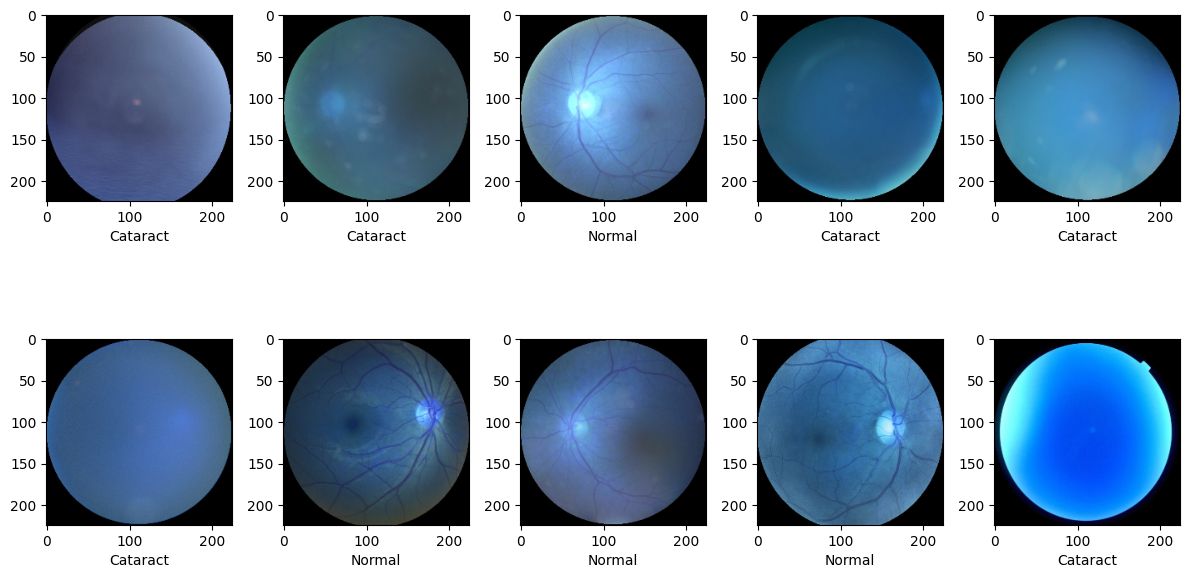

In [ ]:
import numpy as np
import pandas as pd
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Set random seed for reproducibility
random.seed(42)

# Read the CSV file
df = pd.read_csv("/content/full_df.csv")

# Define a function to check if a keyword contains "cataract"
def has_cataract(text):
    if "cataract" in text:
        return 1
    else:
        return 0

# Create new columns for left and right cataract
df["left_cataract"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_cataract(x))
df["right_cataract"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_cataract(x))

# Print the count of right cataract samples
print(df.right_cataract.value_counts())

# Get the filenames of left and right cataract images
left_cataract = df.loc[(df.C == 1) & (df.left_cataract == 1)]["Left-Fundus"].values
right_cataract = df.loc[(df.C == 1) & (df.right_cataract == 1)]["Right-Fundus"].values

# Print the first few filenames
print(left_cataract[:10])
print(right_cataract[:15])

# Print the number of images in left and right cataract
print("Number of images in left cataract: {}".format(len(left_cataract)))
print("Number of images in right cataract: {}".format(len(right_cataract)))

# Get a sample of normal fundus images for both left and right eyes
left_normal = df.loc[(df.C == 0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(300, random_state=42).values
right_normal = df.loc[(df.C == 0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(300, random_state=42).values

# Print the first few filenames
print(right_normal[:15])

# Concatenate cataract and normal filenames
cataract = np.concatenate((left_cataract, right_cataract), axis=0)
normal = np.concatenate((left_normal, right_normal), axis=0)

# Print the number of cataract and normal images
print(len(cataract), len(normal))

# Define the dataset directory and image size
dataset_dir = "/content/gdrive/MyDrive/Computer_vision_project/preprocessed_images"
image_size = 224

# Create an empty list for storing image data and labels
dataset = []

# Function to create the dataset
def create_dataset(image_category, label):
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir, img)
        try:
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            image = cv2.resize(image, (image_size, image_size))
        except:
            continue
        
        dataset.append([np.array(image), np.array(label)])
    
    random.shuffle(dataset)
    return dataset

# Create the cataract dataset
dataset = create_dataset(cataract, 1)

# Print the length of the cataract dataset
print(len(dataset))

# Create the normal dataset
dataset = create_dataset(normal, 0)

# Print the length of the normal dataset
print(len(dataset))

# Plot a sample of images from the dataset
plt.figure(figsize=(12, 7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    label = "Normal" if category == 0 else "Cataract"
    plt.subplot(2, 5, i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()

# Split the dataset into features (x) and labels (y)
x = np.array([i[0] for i in dataset]).reshape(-1, image_size, image_size, 3)
y = np.array([i[1] for i in dataset])

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


58889256/58889256 [==============================] - 1s 0us/step


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 21,137,729
Trainable params: 21,137,729
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
30/30 [==========================

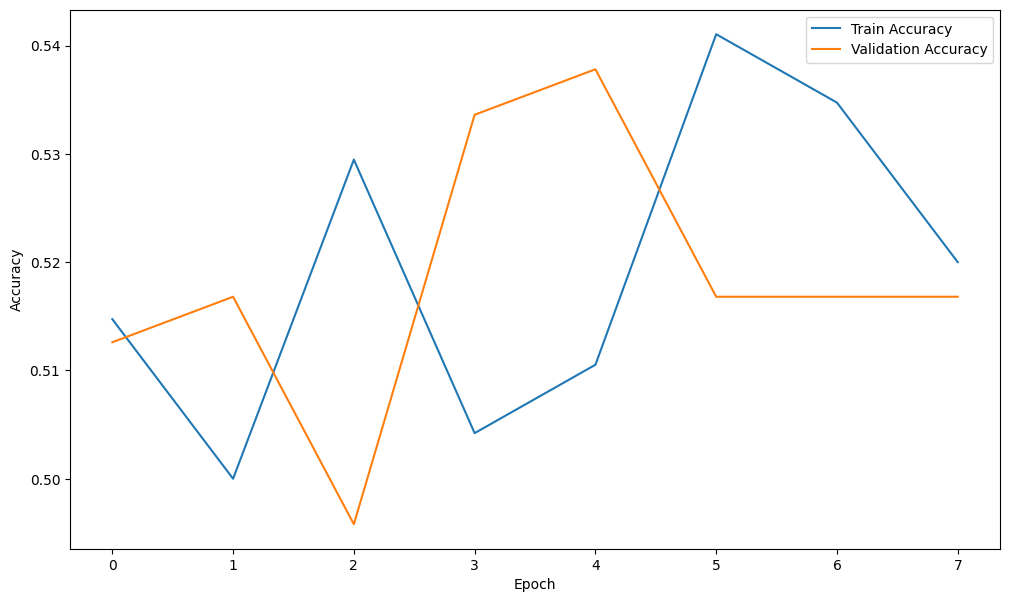

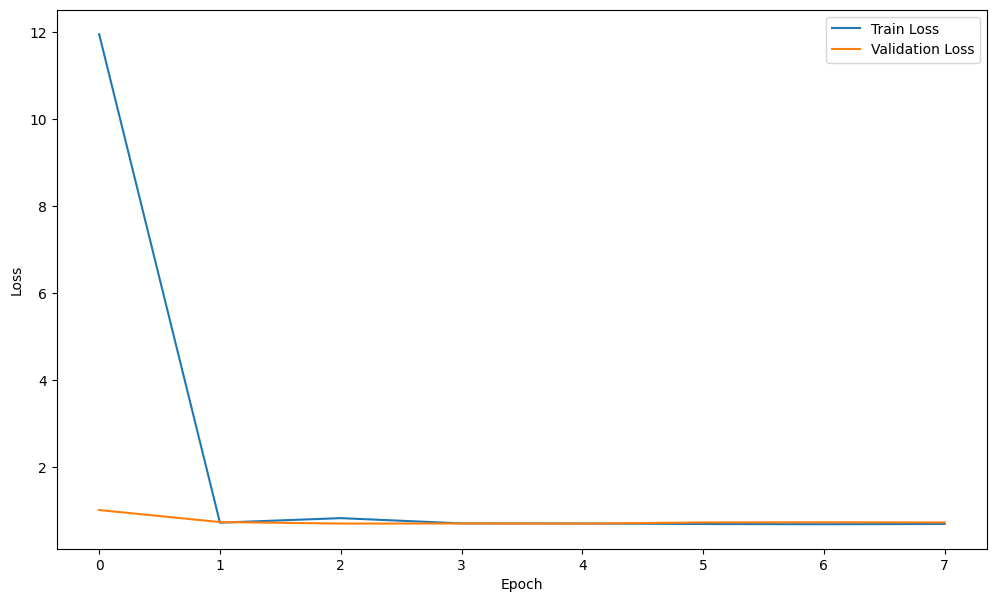

8/8 [==============================] - 145s 18s/step


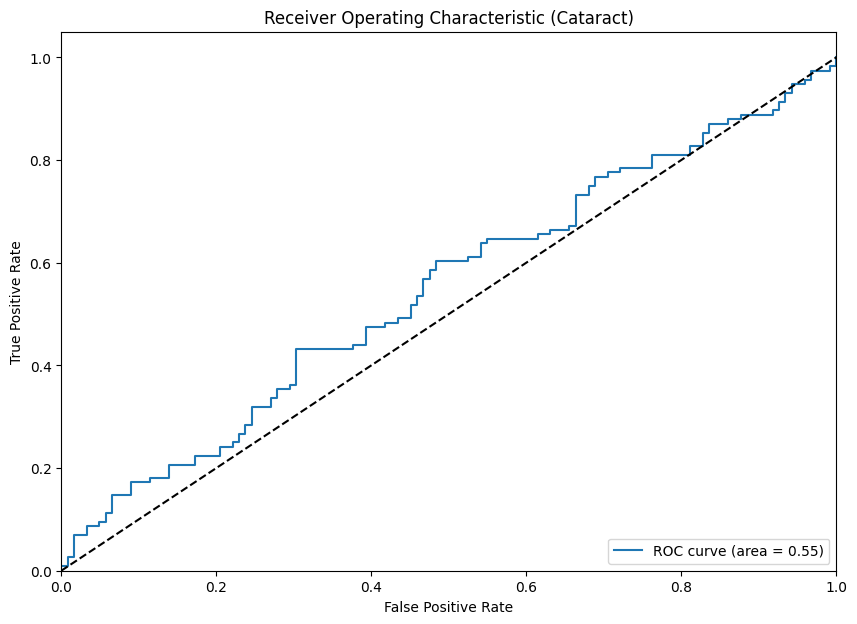

              precision    recall  f1-score   support

      Normal       0.53      0.93      0.67       122
    Cataract       0.64      0.12      0.20       116

    accuracy                           0.54       238
   macro avg       0.58      0.53      0.44       238
weighted avg       0.58      0.54      0.44       238

8/8 [==============================] - 146s 18s/step - loss: 0.6907 - accuracy: 0.5378
Test Loss: 0.6906895637512207
Test Accuracy: 0.5378151535987854


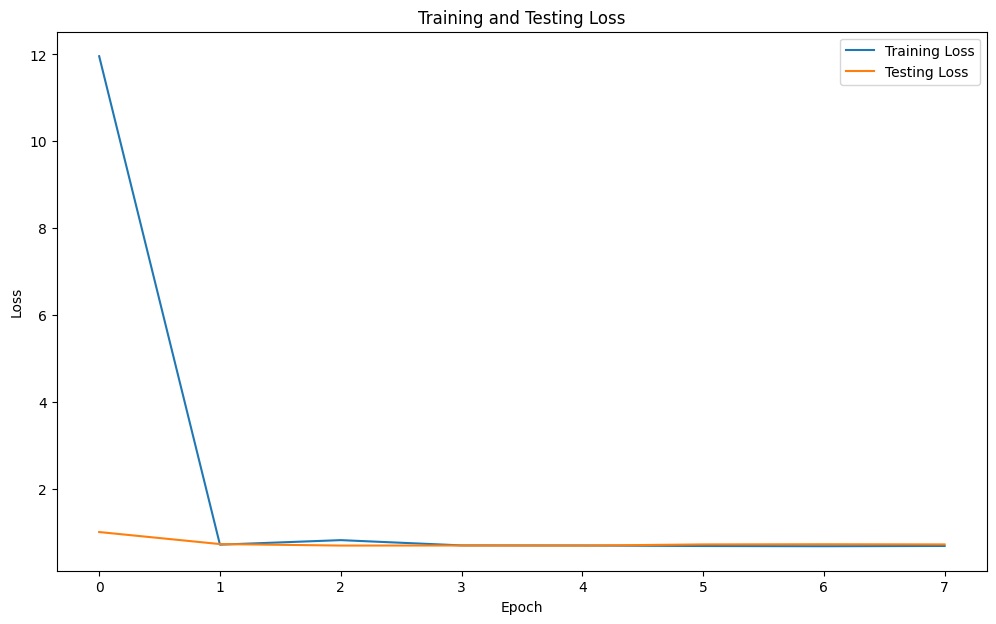

Training Time: 18881.079878091812 seconds


In [ ]:
import time
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Start the timer
start_time = time.time()

# Load the pre-trained VGG16 model
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Create a new model based on VGG16
model = Sequential()
model.add(vgg16)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Define early stopping callback
early_stopping = EarlyStopping(patience=3, monitor='val_loss', mode='min', restore_best_weights=True)

# Train the model
history = model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_test, y_test), callbacks=[early_stopping])

# Evaluate the model on the testing set
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

# Plot the training history
plt.figure(figsize=(12, 7))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss
plt.figure(figsize=(12, 7))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Generate predictions on the testing set
y_pred = model.predict(x_test)
y_pred_binary = (y_pred > 0.5).astype(int)

# Convert labels to binary format
y_test_binary = label_binarize(y_test, classes=[0, 1])
y_pred_proba = y_pred

# Compute ROC curve and AUC for each class
fpr, tpr, _ = roc_curve(y_test_binary, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve for cataract class
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Cataract)')
plt.legend(loc="lower right")
plt.show()

# Generate classification report
target_names = ['Normal', 'Cataract']
classification_rep = classification_report(y_test, y_pred_binary, target_names=target_names)
print(classification_rep)

# Evaluate the model on the testing set
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

# Plot the training and validation loss
plt.figure(figsize=(12, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Testing Loss')
plt.show()

# Calculate the training time
training_time = time.time() - start_time

# Print the training time
print('Training Time:', training_time, 'seconds')
